<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertAndInferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the first and second steps in the split workflow on Terra

DICOM files are downloaded and converted to NIFTI files. NIFTI files are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [2]:
%%capture
#Installing lz4 for compression/decompression; dcm2niix and plastimatch for conversion; 
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 xvfb dcm2niix pigz plastimatch ffmpeg

In [3]:
%%capture
#Installing Totalsegmentator for Inference
#pyradiomics required for extracting radiomics features 
#nvidia-ml-py3 for capturing gpu utilization
!pip install TotalSegmentator pyradiomics nvidia-ml-py3

In [4]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

###Importing Packages

In [5]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
import nvidia_smi
import subprocess

In [6]:
curr_dir   = Path().absolute()

os.environ['TZ'] = 'US/Eastern'
time.tzset()
current_time = time.strftime('%a %b %d %H:%M:%S %Y', time.localtime())
print(current_time)
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Sat Apr 01 13:16:08 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Parameters for papermill

In [7]:
converterType='dcm2niix'
csvFilePath=''

###Reading CSV File containing s5cmd Urls

In [8]:
#get the path of the zip file containing csv file in the current working directory3
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.


#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path= '/home/vamsi/Downloads/result.csv'
#csvFilePath=csvFilePath.replace("gs://", "/cromwell_root/")

start_time = time.time()
#cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
cohort_df= pd.read_csv('/content/drive/MyDrive/idc/bq-results-20230315-160529-1678896367937.csv')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 1.0123786926269531  seconds


In [9]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].sample(n=10).values.tolist()
#SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
#SeriesInstanceUIDs=[ '1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
# '1.2.840.113654.2.55.99651797089556982668213819691341139949'  
# ]

###Defining Functions

In [10]:
#Creating Directories for conversion
if converterType.lower()=='dcm2niix':
  try:
    shutil.rmtree('dcm2niix')
  except OSError:
    pass
  os.mkdir('dcm2niix')
else:
  try:
    shutil.rmtree('plastimatch')
  except OSError:
    pass
  os.mkdir('plastimatch')

In [11]:
#create directory for TotalSegmentator Output files

try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')

In [12]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat 

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [13]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [14]:
def check_dicom_conversion_errors(series_id_folder_path):
    nifti_files = os.listdir(series_id_folder_path)
    if len(nifti_files) > 1:
        with open('error_file.txt', 'a') as f:
            f.write(f"Error: More than one file in {series_id_folder_path}\n")
        return True
    else:
        return False

In [15]:
def inferenceTotalSegmentator(series_id):

      start_time = time.time()
      download_dicom_data(series_id)
      dicom_download_time = time.time() - start_time      

      start_time = time.time()
      convert_dicom_to_nifti(series_id)
      dicom_conversion_time = time.time() - start_time     

      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')
      os.mkdir(f'metadata/{series_id}')

      print("Processing series: "+series_id)  


      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      
      if not check_dicom_conversion_errors(series_id_folder_path):

        # start_time = time.time()
        # !TotalSegmentator -i {nifti_filename_path} -o {curr_dir}/Inference/{series_id}/{series_id}.nii.gz --ml --fast --preview  --radiomics 
        # total_segmentator_time = time.time() - start_time

        # start_time = time.time()     
        # !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii.gz  {curr_dir}/Inference/{series_id}/{series_id}.nii.gz.lz4
        # archiving_time = time.time() - start_time


        start_time = time.time()
        !TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
        total_segmentator_time = time.time() - start_time

        try:
          subprocess.run(["mv", f"{curr_dir}/preview_total.png", f"{curr_dir}/segmentations.nii", f"{curr_dir}/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
          print("Files moved successfully using the first command")
        except subprocess.CalledProcessError:
          try:
            subprocess.run(["mv", "segmentations/preview_total.png", "segmentations/segmentations.nii", "segmentations/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
          except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")
        
        #!mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
        !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
        !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
        !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

        start_time = time.time()  
        !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
        !tar cvf - {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png | lz4 > {curr_dir}/metadata/{series_id}/{series_id}_metadata.tar.lz4
        archiving_time = time.time() - start_time

      else: 
        total_segmentator_time=0
        archiving_time=0

      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 

      log['dicom_download_time']=dicom_download_time
      log['dicom_conversion_time']=dicom_conversion_time            
      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png
      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [16]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

###Total Segmentator

Copying files from IDC buckets..
Done in 2.5517 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 433 DICOM file(s)
Convert 433 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227/1.3.6.1.4.1.14519.5.2.1.7009.9004.10669253193448407234530875722_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x433x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227/1.3.6.1.4.1.14519.5.2.1.7009.9004.10669253193448407234530875722_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 27.128176 seconds (0.708054 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Download finished. Extracting...
  downloaded i

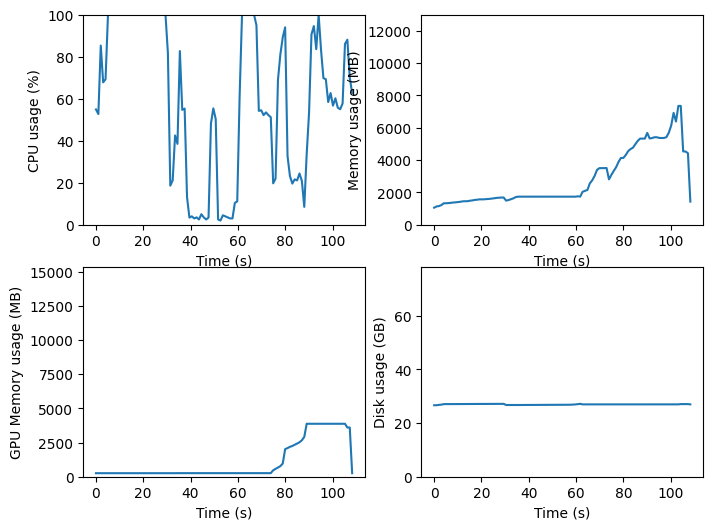

Copying files from IDC buckets..
Done in 2.32434 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 392 DICOM file(s)
Convert 392 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744194658033491482525/1.3.6.1.4.1.14519.5.2.1.7009.9004.17946717074419465803349148252_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x392x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744194658033491482525/1.3.6.1.4.1.14519.5.2.1.7009.9004.17946717074419465803349148252_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 13.420697 seconds (0.640634 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744194658033491482525

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.25s
Predicting.

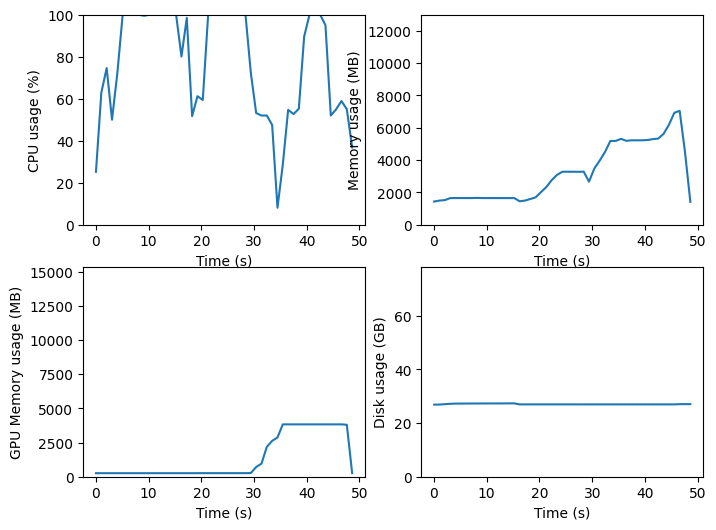

Copying files from IDC buckets..
Done in 2.34082 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 447 DICOM file(s)
Convert 447 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.17313147964480306532752553676_2_OPA_GE_LS16_STANDARD_440_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x447x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.17313147964480306532752553676_2_OPA_GE_LS16_STANDARD_440_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 15.622250 seconds (0.752604 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.86s
Predicting.

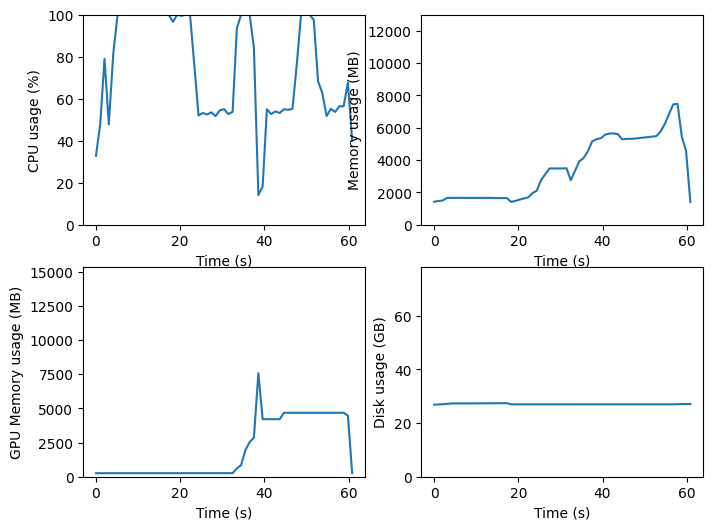

Copying files from IDC buckets..
Done in 2.57399 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 399 DICOM file(s)
Convert 399 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.285770339622347134666382899746/1.3.6.1.4.1.14519.5.2.1.7009.9004.28577033962234713466638289974_2_OPA_GE_LS16_STANDARD_280_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x399x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.285770339622347134666382899746/1.3.6.1.4.1.14519.5.2.1.7009.9004.28577033962234713466638289974_2_OPA_GE_LS16_STANDARD_280_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 11.963053 seconds (0.784251 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.285770339622347134666382899746

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.72s
Predicting.

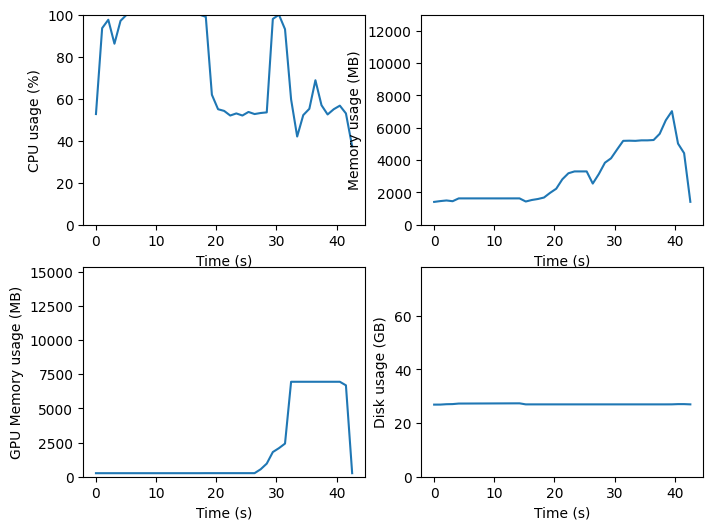

Copying files from IDC buckets..
Done in 2.65076 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 434 DICOM file(s)
Convert 434 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742298075458308510165/1.3.6.1.4.1.14519.5.2.1.7009.9004.24153434274229807545830851016_2_OPA_GE_LS16_STANDARD_380_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x434x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742298075458308510165/1.3.6.1.4.1.14519.5.2.1.7009.9004.24153434274229807545830851016_2_OPA_GE_LS16_STANDARD_380_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 15.121220 seconds (0.708237 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742298075458308510165

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.03s
Predicting.

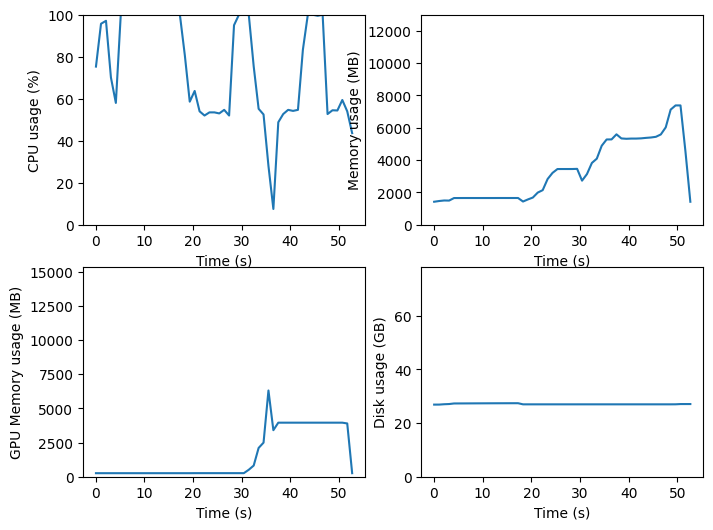

Copying files from IDC buckets..
Done in 2.42601 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 439 DICOM file(s)
Convert 439 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.286959303245994955177283621519/1.3.6.1.4.1.14519.5.2.1.7009.9004.28695930324599495517728362151_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x439x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.286959303245994955177283621519/1.3.6.1.4.1.14519.5.2.1.7009.9004.28695930324599495517728362151_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 14.451698 seconds (0.828048 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.286959303245994955177283621519

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.31s
Predicting.

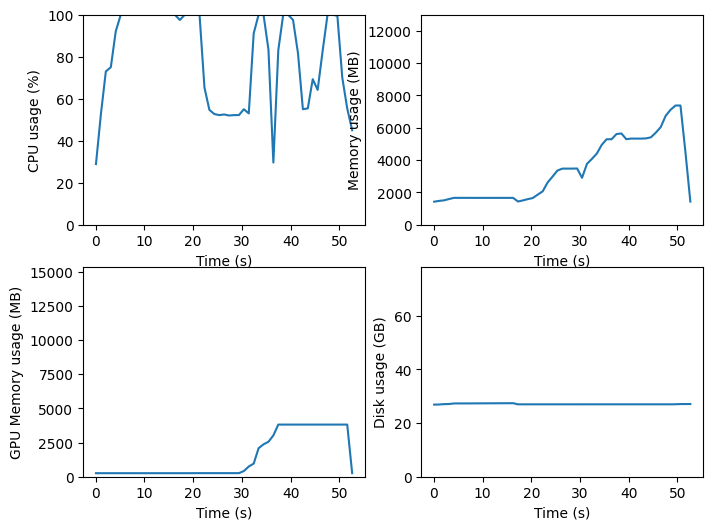

Copying files from IDC buckets..
Done in 1.52077 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 215 DICOM file(s)
Convert 215 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.357189156582659485068355400016/1.3.6.1.4.1.14519.5.2.1.7009.9004.35718915658265948506835540001_2_OPA_GE_LSPR16_STANDARD_440_1.2_120_80_58.2_1.4_20010102000000_3 (512x512x215x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.357189156582659485068355400016/1.3.6.1.4.1.14519.5.2.1.7009.9004.35718915658265948506835540001_2_OPA_GE_LSPR16_STANDARD_440_1.2_120_80_58.2_1.4_20010102000000_3.nii"
Conversion required 5.980288 seconds (0.384779 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.357189156582659485068355400016

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 3.27s
Predicti

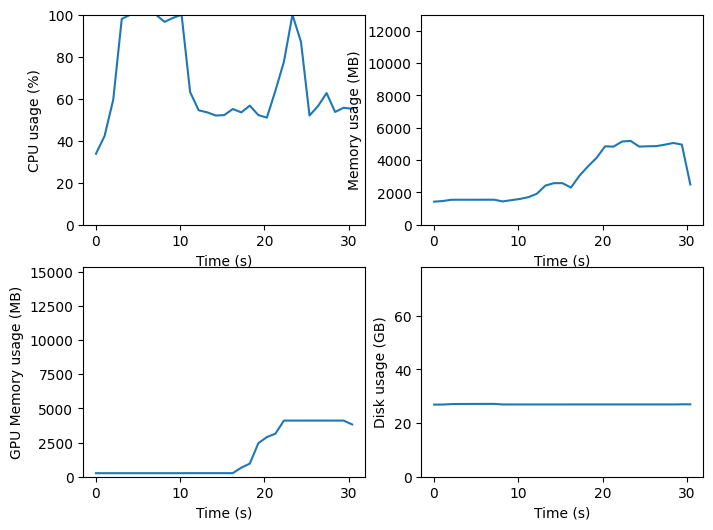

Copying files from IDC buckets..
Done in 2.63062 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 484 DICOM file(s)
Convert 484 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.108911886400922752821031174557/1.3.6.1.4.1.14519.5.2.1.7009.9004.10891188640092275282103117455_1_OPA_GE_LSPR16_STANDARD_340_1.2_120_80_58.2_1.4_20000102000000_3 (512x512x484x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.108911886400922752821031174557/1.3.6.1.4.1.14519.5.2.1.7009.9004.10891188640092275282103117455_1_OPA_GE_LSPR16_STANDARD_340_1.2_120_80_58.2_1.4_20000102000000_3.nii"
Conversion required 12.815517 seconds (0.912366 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.108911886400922752821031174557

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.77s
Predict

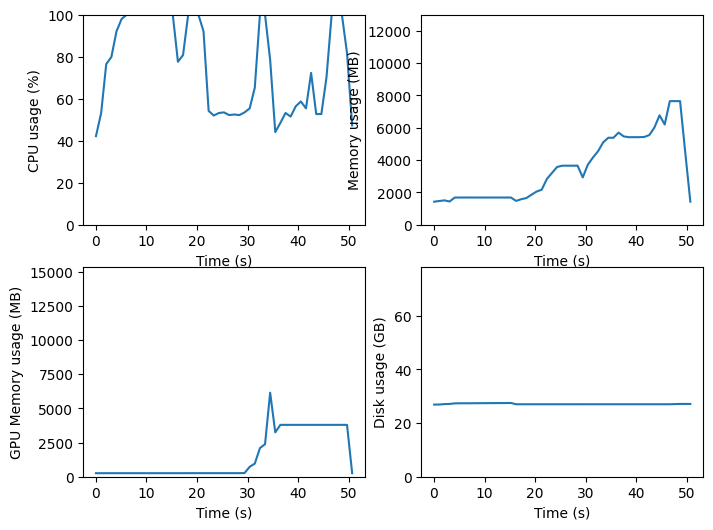

Copying files from IDC buckets..
Done in 2.43573 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 449 DICOM file(s)
Convert 449 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.324162574998963579714997061217/1.3.6.1.4.1.14519.5.2.1.7009.9004.32416257499896357971499706121_0_OPA_GE_LSULT_STANDARD_360_1.2_120_80_59.3_1.4_19990102000000_3 (512x512x449x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.324162574998963579714997061217/1.3.6.1.4.1.14519.5.2.1.7009.9004.32416257499896357971499706121_0_OPA_GE_LSULT_STANDARD_360_1.2_120_80_59.3_1.4_19990102000000_3.nii"
Conversion required 13.309093 seconds (0.730871 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.324162574998963579714997061217

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 7.27s
Predictin

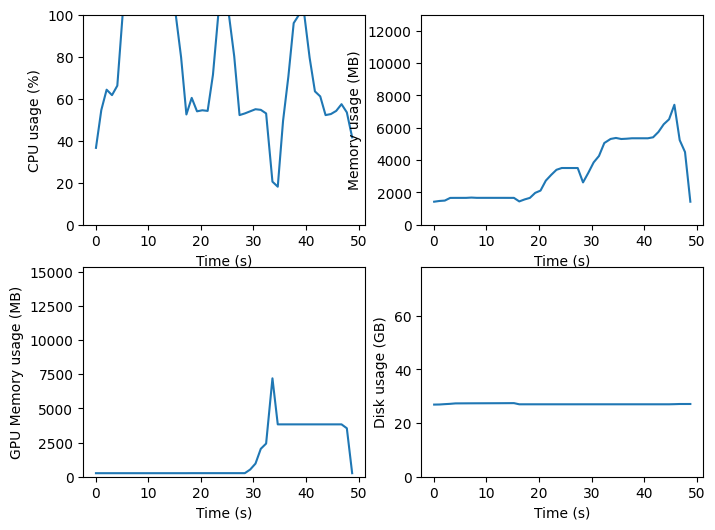

Copying files from IDC buckets..
Done in 2.53818 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 421 DICOM file(s)
Convert 421 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488928220975506383328/1.3.6.1.4.1.14519.5.2.1.7009.9004.25645058248892822097550638332_2_OPA_GE_LS16_STANDARD_310_1.2_120_70_50.9_1.4_20010102000000_2 (512x512x421x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488928220975506383328/1.3.6.1.4.1.14519.5.2.1.7009.9004.25645058248892822097550638332_2_OPA_GE_LS16_STANDARD_310_1.2_120_70_50.9_1.4_20010102000000_2.nii"
Conversion required 13.695061 seconds (0.820882 for core code).
Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488928220975506383328

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.04s
Predicting.

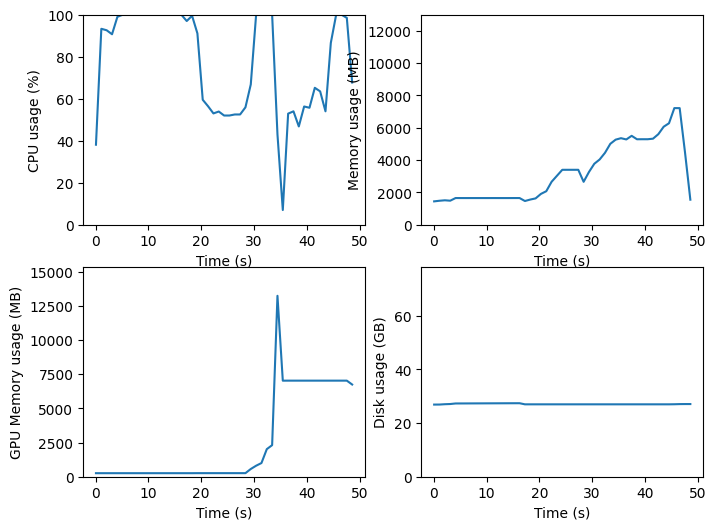

In [17]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time','dicom_download_time','dicom_conversion_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
    #for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [18]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
!tar cvf - metadata | lz4 > inferenceMetaData.tar.lz4
output_file_archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227/1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488928220975506383328/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488928220975506383328/1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488928220975506383328.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742298075458308510165/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742298075458308510165/1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742298075458308510165.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744194658033491482525/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744194658033491482525/1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744194658033491482525.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.357189156582659485068355400016/
Inference/1.3.6.1

###Utilization Metrics

In [19]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_file_archiving_time']=output_file_archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 29948 bytes into 11860 bytes ==> 39.60%


,SeriesInstanceUID,total_segmentator_time,dicom_download_time,dicom_conversion_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total,output_file_archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934...,77.619434,2.673978,27.292701,0.235595,"[[[54.9, 52.7, 85.3, 67.8, 69.3, 100.0, 100.0,...","[[[1053.0, 1130.453125, 1151.62109375, 1213.86...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.608905792236328, 26.618240356445312, 26....",78.189842,0.345645
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.179467170744...,32.249513,2.446846,13.555799,0.229592,"[[[25.2, 62.9, 74.6, 50.0, 72.2, 100.0, 100.0,...","[[[1433.5546875, 1494.28515625, 1520.59375, 16...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.841415405273438, 26.870418548583984, 27....",78.189842,0.345645
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644...,41.999947,2.467032,15.810368,0.233615,"[[[32.8, 48.0, 79.0, 47.8, 81.7, 100.0, 100.0,...","[[[1420.98046875, 1466.6015625, 1496.96875, 16...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.843910217285156, 26.8741455078125, 27.03...",78.189842,0.345645
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.285770339622...,27.148205,2.704400,12.064112,0.242567,"[[[52.7, 93.6, 97.6, 86.2, 97.1, 100.0, 100.0,...","[[[1410.90625, 1461.65234375, 1499.96484375, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.84626007080078, 26.856029510498047, 26.9...",78.189842,0.345645
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.241534342742...,34.159226,2.788104,15.266584,0.234498,"[[[75.3, 95.7, 97.1, 70.1, 58.0, 100.0, 100.0,...","[[[1420.6328125, 1466.390625, 1498.3984375, 14...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.848838806152344, 26.85810089111328, 26.9...",78.189842,0.345645
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.286959303245...,35.178660,2.563002,14.555087,0.236718,"[[[28.9, 52.7, 73.0, 75.0, 92.1, 100.0, 100.0,...","[[[1424.53125, 1473.57421875, 1506.66796875, 1...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.851268768310547, 26.88623809814453, 27.0...",78.189842,0.345645
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.357189156582...,22.720133,1.652493,6.134375,0.241513,"[[[33.8, 42.2, 59.5, 98.0, 100.0, 100.0, 100.0...","[[[1425.71484375, 1465.51171875, 1543.23046875...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.854084014892578, 26.875988006591797, 27....",78.189842,0.345645
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.108911886400...,34.691272,2.781971,12.937834,0.236894,"[[[42.2, 53.1, 76.5, 79.9, 92.1, 98.0, 100.0, ...","[[[1423.8828125, 1467.26171875, 1506.27734375,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.855159759521484, 26.887348175048828, 27....",78.189842,0.345645
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.324162574998...,32.249507,2.475784,13.460288,0.245673,"[[[36.6, 54.6, 64.3, 61.7, 66.2, 100.0, 100.0,...","[[[1423.2421875, 1469.1875, 1492.8046875, 1657...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.857852935791016, 26.893428802490234, 27....",78.189842,0.345645
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.256450582488...,32.081038,2.686490,13.882713,0.241440,"[[[38.1, 93.3, 92.6, 90.7, 99.0, 100.0, 100.0,...","[[[1444.1875, 1482.16015625, 1510.48828125, 14...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.86007308959961, 26.874237060546875, 26.9...",78.189842,0.345645
